# **Hong Kong Instagram Username Identification**

**Objective**: To classify if the Instagram Username is non-Hong-Kong (0) or Hong Kong (1).

**Outline**:

1. [**Data Collection**](#1-data-collection)  
    - [1.1 Scraping](#11-scraping)  
2. [**Data Preprocessing**](#2-data-preprocessing)  
    - [2.1 Merging Datasets and Labelling](#21-merging-datasets-and-labelling)  
    - [2.2 Data Cleaning](#22-data-cleaning)  
    - [2.3 Tokenization](#23-tokenization)  
    - [2.4 Encoding](#24-encoding)  
3. [**Data Exploration**](#3-data-exploration)  
    - [3.1 Distribution of non-HK and HK entries](#31-distribution-of-non-hk-and-hk-entries)  
    - [3.2 Distribution of Repeated and Unique Syllables](#32-distribution-of-repeated-and-unique-syllables)  
    - [3.3 Visualizing the Potential Patterns between Syllables using t-SNE](#33-visualizing-the-potential-patterns-between-syllables-using-t-sne)  
    - [3.4 Further Analysis on the Syllables using Linguistics](#34-further-analysis-on-the-syllables-using-linguistics)  
4. [**Hyperparameter Tuning**](#4-hyperparameter-tuning)  
    - [4.1 Data Splitting](#41-data-splitting)
    - [4.2 Choosing Models for Hyperparameter Tuning](#42-choosing-models-for-hyperparameter-tuning)  
    - [4.3 Hyperparameter Tuning](#43-hyperparameter-tuning)  
5. [**Model Testing**](#5-model-testing)  
    - [5.1 Confusion Matrix](#51-confusion-matrix)  
6. [**Evaluation and Conclusion**](#6-evaluation-and-conclusion)  
    - [6.1 Model Selection](#61-model-selection)  
    - [6.2 Limitations](#62-limitations)  
    - [6.3 Thank you & Further Directions](#63-thank-you--further-directions)

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.tokenize import SyllableTokenizer

from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

SEED = 42 # set the random seed to 42 for reproducibility

## 1. Data Collection

### 1.1 Scraping

The data is collected from [HypeAuditor](https://hypeauditor.com/) using [hypeauditor_scraper.py](hypeauditor_scraper.py). You may either use the pre-scraped datasets stored in the [datasets](datasets) or manually scrape the data by following the instructions below.

**To Use the Scraper**: 
1. Download the required libraries and chrome driver by following the instructions in [Eslite Scraper](https://github.com/kuntiniong/Eslite-Scraper)
2. Uncomment code block [2]&[3] and comment out [4]
3. Delete "datasets" file
4. Register an account on HypeAuditor using gmail
5. Execute the code

> *Note: By the context of HK and non-HK usernames, it is referring to the top 1000 most popular Instagram users in Hong Kong and India on HypeAuditor*

In [2]:
# from hypeauditor_scraper import HypeAuditorScraper

# gmail = "<your gmail>"
# password = "<password>"

# scraper = HypeAuditorScraper()
# hongkong_username_df = scraper.scrape(gmail, password, hongkong = True)
# non_hongkong_username_df = scraper.scrape(gmail, password, hongkong = False)

In [3]:
# datasets_folder_path = os.path.join(os.getcwd(), 'datasets')
# os.makedirs(datasets_folder_path)
# os.chdir(datasets_folder_path)
# hongkong_username_df.to_csv("hongkong_username.csv")
# non_hongkong_username_df.to_csv("non_hongkong_username.csv")

## 2. Data Preprocessing

### 2.1 Merging Datasets and Labelling

Merge **hongkong_username.csv** and **non_hongkong_username.csv** into a dataframe and label non-HK users as **0** and HK users as **1**. 

In [4]:
# comment out this block if you wish to use the scraper
datasets_folder_path = os.path.join(os.getcwd(), 'datasets') 
os.chdir(datasets_folder_path)

In [5]:
hongkong_username_df = pd.read_csv("hongkong_username.csv")
hongkong_username_df["Hong Kong"] = 1
non_hongkong_username_df = pd.read_csv("non_hongkong_username.csv")
non_hongkong_username_df["Hong Kong"] = 0

df = pd.concat([hongkong_username_df, non_hongkong_username_df], axis = 0, ignore_index = True)
df = df.drop(df.columns[0], axis = 1)
df

,IG Username,Hong Kong
0,gem0816,1
1,derek_tch,1
2,kelly.fuu,1
3,ansonlht,1
4,keung_show,1
...,...,...
1995,official_mayaali,0
1996,r_rajesh_07,0
1997,rterdogan,0
1998,surbhijyoti,0


### 2.2 Data Cleaning

Drop duplicates.

In [6]:
original_size = len(df['IG Username'])
df = df.drop_duplicates(subset=['IG Username']) 
new_size1 = len(df['IG Username'])

print(f'{original_size - new_size1} duplicated entries are removed, {new_size1} entries are retained.')

127 duplicated entries are removed, 1873 entries are retained.


Remove numbers and punctuations as they don't contain much info and drop empty entries.

In [7]:
df["IG Username"] = df["IG Username"].apply(lambda x: re.sub(r'[\d._]+', '', x)) 
df = df[df['IG Username'] != ""] 
new_size2 = len(df['IG Username'])

print(f'{new_size1 - new_size2} empty entries are removed, {new_size2} entries are retained.')

1 empty entries are removed, 1872 entries are retained.


### 2.3 Tokenization

Reasons to tokenize usernames based on syllables:

* **Usernames don't contain whitespaces** 
    - Lack of whitespaces in the IG usernames makes the traditional tokenizers that heavily rely on whitespaces can't work properly

* **Usernames are not sentences**
    - In other words, usernames are too short to extract a "word" as a unit for the features

* **Usernames are not proper English**
    - Any conventional tokenizers won't have the word embeddings for usernames, so a **subword tokenizer** that tokenizes a word based on the **prefixes** and **suffixes** would also *not* work

* **No existing Romanized Cantonese-specific tokenizer**
    - As demonstrated in the last part, syllabic tokenizer can somehow still be able to extract some unique patterns, albeit the lack of Romanized Cantonese word embeddings           

In [8]:
tokenizer_model = SyllableTokenizer()

df["Tokenized IG Username"] = df["IG Username"].apply(lambda x: np.array(tokenizer_model.tokenize(x))) 
df["Tokenized IG Username"]
df

,IG Username,Hong Kong,Tokenized IG Username
0,gem,1,[gem]
1,derektch,1,"[de, rektch]"
2,kellyfuu,1,"[kel, ly, fuu]"
3,ansonlht,1,"[an, sonlht]"
4,keungshow,1,"[keungs, how]"
...,...,...,...
1995,officialmayaali,0,"[of, fi, cial, may, a, a, li]"
1996,rrajesh,0,"[rra, jesh]"
1997,rterdogan,0,"[rter, do, gan]"
1998,surbhijyoti,0,"[surb, hi, jyo, ti]"


### 2.4 Encoding

Convert syllables into binaries.

In [9]:
unique_syllables = df["Tokenized IG Username"].explode().unique()

for i in unique_syllables:
  df[i] = df["Tokenized IG Username"].apply(lambda syllable_list: int(i in syllable_list))

X = df.iloc[:,3:]
X

,gem,de,rektch,kel,ly,fuu,an,sonlht,keungs,how,...,dwa,moor,shar,dult,goul,rra,jesh,rter,jyo,miks
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## 3. Data Exploration

### 3.1 Distribution of non-HK and HK Entries 

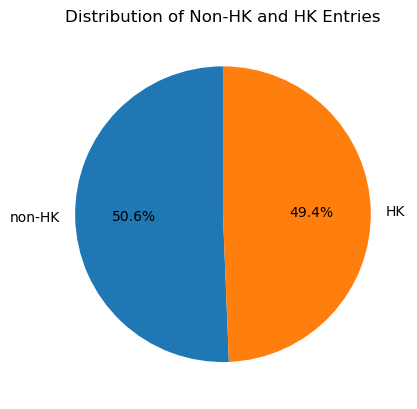

In [10]:
# data
def getData(hk):
  return len(df.loc[(df['Hong Kong'] == hk), 'Hong Kong'])

# plot
plt.title("Distribution of Non-HK and HK Entries")
plt.pie([getData(0), getData(1)], 
        labels = ['non-HK', 'HK'], 
        autopct = '%1.1f%%', startangle=90);

 In this case, the distribution is balanced with non-HK comprises 50.6% and HK comprises 49.4% of the entries.

### 3.2 Distribution of Repeated and Unique Syllables

Repeated syllables can act as patterns for the models to do classfication.

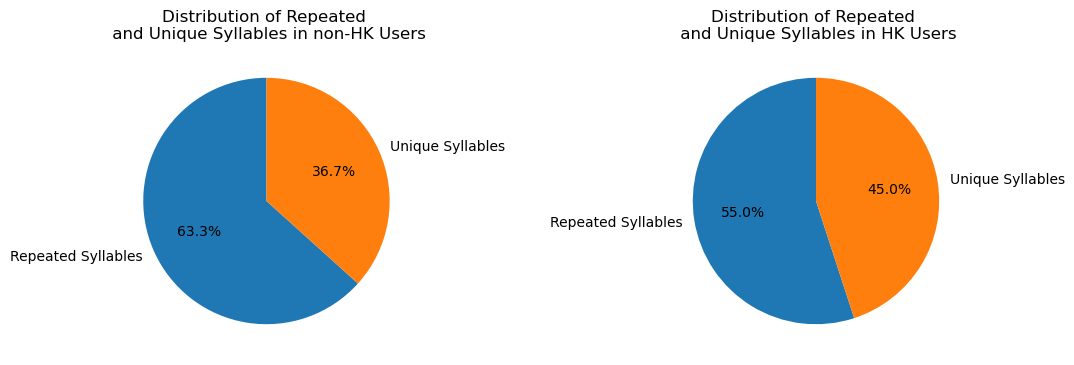

In [11]:
def getData(hk):
  return df.loc[(df['Hong Kong'] == hk), 'Tokenized IG Username']

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

for i in range(2):
  
  # data
  total_syllables = len(getData(i).explode())
  unique_syllables = len(getData(i).explode().unique())
  repeated_syllables = total_syllables - unique_syllables

  title = "HK" if i else "non-HK"
  
  # plot
  ax[i].set_title(f"Distribution of Repeated \n and Unique Syllables in {title} Users")
  ax[i].pie([repeated_syllables, unique_syllables], 
          labels = ['Repeated Syllables', 'Unique Syllables'], autopct = '%1.1f%%', startangle=90);

From above, we can see that (63.3% repeated, 36.7% unique) for Non-HK users and (55.0% repeated, 45.0% unique) for HK users. Overall, Non-HK users have a higher percentage of repeated syllables.

The distribution of repeated and unique syllables are **quiet reasonable** as there are multiple syllables in the username and the model might fail to capture the pattern of the usernames if there are too much repeated syllables.

### 3.3 Visualizing the Potential Patterns between Syllables using t-SNE

To use an unsupervised dimensionality reduction technique t-SNE to visualize of the possible underlying patterns of syllables in the usernames. 

In this case, dim(2425) is reduced to dim(2).

In [12]:
X.shape

(1872, 2425)

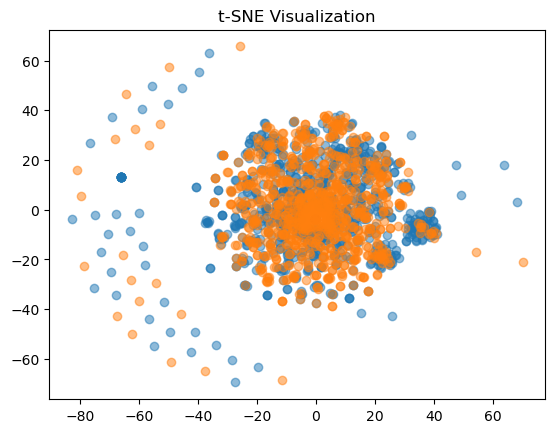

In [13]:
# transform
tsne = TSNE(n_components = 2, random_state = SEED)
X_tsne = tsne.fit_transform(X)

# data
df_tsne = pd.DataFrame(data = X_tsne, columns = ['tsne_x', 'tsne_y'])
df_tsne["target"] = df['Hong Kong']

# plot
plt.title("t-SNE Visualization")

for i in range(2):
  color = ['tab:blue', 'tab:orange']
  plt.scatter(x = df_tsne.loc[(df_tsne['target'] == i), 'tsne_x'], 
              y = df_tsne.loc[(df_tsne['target'] == i), 'tsne_y'], 
              color = color[i], alpha = 0.5);

From the graph above, no useful insights can be observed as the scatters **do not form any distinct clusters**.

A possible factor to this might be each syllable in the usernames is treated independently (per column) but not the entire username (per row), so the **order of the syllables are not taken into account**. 

In addition, information loss during the dimensionality reduction could also be the reason considering the dataset is small and each feature might only have a few entries. Therefore, the resulting t-SNE plot may not reveal distinct clusters or patterns in the data.

### 3.4 Further Analysis on the Syllables using Linguistics

To highlight some of the interesing naming patterns and behavior of the syllable tokenizer of both non-HK and HK users.


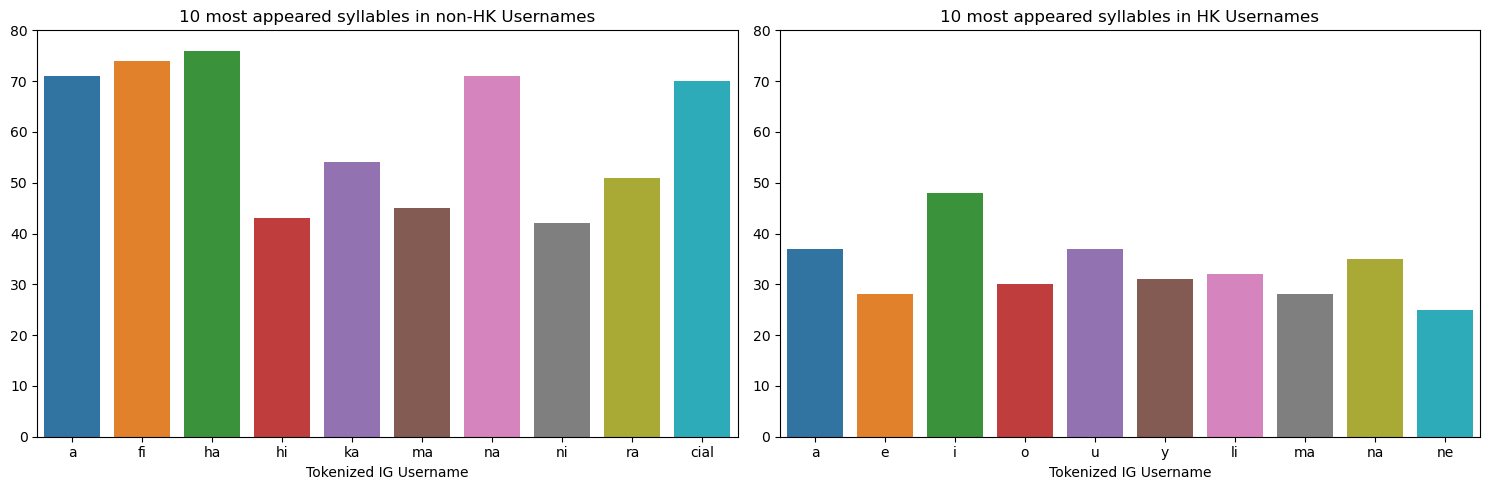

In [14]:
# data
def getData(hk):
  return df.loc[(df["Hong Kong"] == hk), "Tokenized IG Username"].explode().value_counts() # already descending

# plot
fig, ax = plt.subplots(1, 2, figsize = (15, 5))

for i in range(2):
  top_ten_freq = getData(i).head(10).sort_index().sort_index(key = lambda x: x.str.len()) # sort alphabetically then sort by length
  x = top_ten_freq.index
  y = top_ten_freq.values

  title = "HK" if i else "non-HK"

  ax[i].set_title(f"10 most appeared syllables in {title} Usernames")
  sns.barplot(x = x, y = y, ax = ax[i])

  ax[i].set_ylim(0, 80)

plt.tight_layout();

> Terminologies:
>
> * **Vowel**: a,e,i,o,u,y* and they *can* be a *standalone syllable*
> * **Consonant**: a character that is not a vowel and *cannot* be a *standalone syllable*
> * **Consonant-vowel (CV) syllable**: a syllable that contains *both* vowels and consonants, e.g. 'fi', 'ha', etc.
> * **Monosyllabic**: a word with single/ one syllable
> 
> *note: y sometimes can act as a vowel as well*

1. **Higher Appearance of Standalone Vowels in HK** -> *Unique Vowel Clusters*
    - Romanized Cantonese has a lot of unique adjacent vowels compared to English or other languages
    - For example: {"張": "ch-***eu***-ng", "楊": "  ***yeu***-ng", "趙": "ch-***iu***", "游": "  ***yau***", ...}
    - The tokenizer is not familiar with these clusters and might treat them as an individual syllable

2.  **Less CV syllables, More Unique Syllables in HK** -> *Complex Consonants Clusters*
    - Romanized Cantonese also has a lot of complex consonants combinations and some can even contain no vowels at all
    - For example : {"翠": "***ts***-ui", "芷": "  ***tsz***", "吳": "***ng***", "郭": "***kw***-ok", ...}
    - This confuses the tokenizer to group the consonants to other vowels, resulting in more unique syllables

3. **Lower Overall Syllable Counts in HK** -> *Monosyllabic Chinese Characters*
    - Hong Kong People's name are mostly made up of 3 Chinese characters, and chinese characters are monosyllabic
    - i.e. Hong Kong people's name at most have 3 syllables and leads to lower overall syllable counts in usernames
    - So the maximum syllable count is around 75 ("ha") in Non-HK while it is only roughly 50 ("i") in HK 
    
All these differences contributed as the **patterns** for the models to identify HK usernames from non-HK usernames.

## 4. Hyperparameter Tuning

### 4.1 Data Splitting

To split the **feature matrix** (X) and **target vector** (y) into training dataset (**80%**) and testing dataset (**20%**). 

In [15]:
X = df.iloc[:,3:]
y = df["Hong Kong"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = SEED)

In [16]:
# check size
data_name_list = ["X_train", "y_train", "X_test", "y_test"]
arr = [X_train, y_train, X_test, y_test]
for i in range(4):
  print(f"Size of {data_name_list[i]}: {arr[i].shape}")

Size of X_train: (1497, 2425)
Size of y_train: (1497,)
Size of X_test: (375, 2425)
Size of y_test: (375,)


### 4.2 Choosing Models for Hyperparameter Tuning

#### Brief explanations of how the three chosen models work: 

1. **Logistic Regression (LR)** 
    * assumes the data follows a Bernoulli distribution (0 or 1)
    * maximizes the likelihood of the data with gradient descent  
    * calculates the probability with the logistic function 

2. **Random Forest (RF)**
    * two types of node in a binary decision tree: 
        * conditional node (set conditions and branch one more pair of condtional and leaf nodes) 
        * leaf node (predicted values/ data that satisfy all the conditions)
    * maximizes the separation of classes by choosing one of the many decision trees (ensemble)
    * create mulitple trees because the conditions set at the root node are arbitrary and can vastly affect the results 
     
3. **Supported Vector Machines (SVM)**
    * treat the data as vectors in a vector space that is higher than original dimensionality of the data (kernal trick)
    * maximizes the margin between classes by finding the optimal hyperplane

#### Visualization of the Decision Boundaries

Though this visualization only gives a partial overview of the decision boundaries, as ```X_test``` is being reduced to 2D with Principal Component Analysis (PCA), it is good enough to show a general idea of how the decision boundaries are formed by different models.

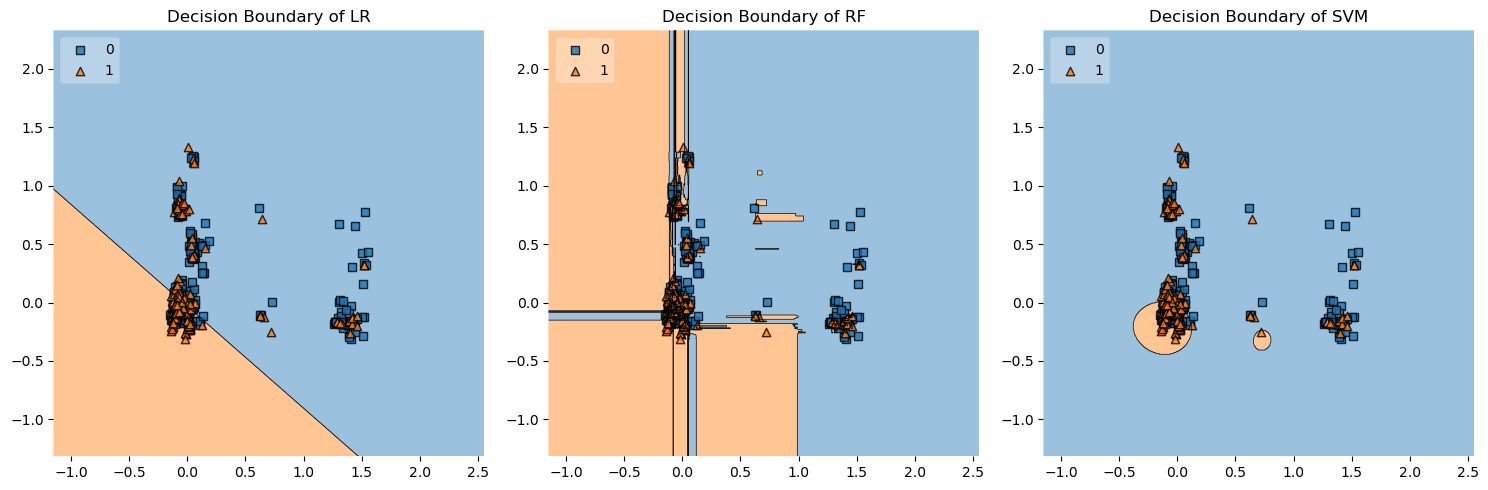

In [17]:
def visualize(X_train, y_train):
  
  models = [('LR', LogisticRegression()),
            ('RF', RandomForestClassifier(random_state=SEED)),
            ('SVM', SVC())]

  fig, ax = plt.subplots(1, 3, figsize = (15, 5)) 

  pca = PCA(n_components = 2)
  re_X_train = pca.fit_transform(X_train)
 
  for i in range(3):    
    clf = models[i][1]
    clf.fit(re_X_train, y_train)
    plot_decision_regions(X = re_X_train, y = y_train.to_numpy().astype(int), clf = clf, legend = 2, ax = ax[i])
    
    name = models[i][0]
    ax[i].set_title(f'Decision Boundary of {name}')

  plt.tight_layout();

visualize(X_train, y_train)

##### Explanation of the Visualization:

1. **Logistic Regression (LR)** 
    * the division boundary is linear 
    * might not be able to capture non-linear relationships

2. **Random Forest (RF)**
    * the division boundary is non-linear 
    * be able to capture very complex non-linear relationships 
    * could be a double-edged sword as it can easily underfit or overfit 
     
3. **Supported Vector Machines (SVM)**
    * the division boundary is non-linear
    * be able to capture non-linear relationships
    * effective in handling high-dimensional features
    * very sensitive to the choice of kernel and its hyperparameters

Overall, SVM has the potential to be the best choice if all the hyperparameters are properly tuned, but since the dataset is small, it is still essential to evaluate and compare the performance of all the models on this specific dataset. 

### 4.3 Hyperparameter Tuning

To use an exhaustive search method  ```GridSearchCV()``` that combines grid search and k-fold validation to tune the hyperparameters. During this process, **hyperparameter tuning, model training and 5-fold validation are performed simultaneously**. 

All the testing hyperparameters are listed in the parameter grid ```param_grid``` and are determined based on accuracy.

#### Brief explanations on the choice of testing hyperparameters:

Since the dataset is small, **contains a lot of features (2425 syllables), and each feature may only have a few entries**, the model might have a higher tendency to memorize the limited samples in the training data set and fail to generalize on unseen data. 

So the **main priority here for tuning the hyperparameters would be to prevent overfitting**.

In [18]:
def hpTuning(X_train, y_train):

  clf = [LogisticRegression(), RandomForestClassifier(random_state = SEED), SVC()] # three different classification models
  param_grid = [{
    'solver': ['liblinear'], # good for small datasets and binary classification; support l1 and l2 regularization
    'penalty': ['l1', 'l2'], # 2 different regularization method to prevent overfitting by adding a penalty term
    'C': [1, 10, 20] # regularization strength; smaller c greater regularization strength 
  },{
    'n_estimators': [100, 150], # number of trees in the 'forest'
    'max_depth': [3, 5, 7] # the data run through how many levels of conditions
  },{
    'C': [1, 10, 20], # smaller c greater margin
    'gamma': ['auto', 'scale'] # 1 / (n_features * X.var()), 1 / n_features
  }]

  best_clf = []
  
  for i in tqdm(range(3)):
    grid_search = GridSearchCV(estimator = clf[i], 
                               param_grid = param_grid[i], 
                               cv = 5,
                               scoring = 'accuracy', 
                               n_jobs = -1) # -1 to enable parallel processing
    
    grid_search.fit(X_train, y_train) # train
    best_clf.append((grid_search.best_estimator_, 
                     grid_search.best_score_))   

  return best_clf

# deploy
best_clf = hpTuning(X_train, y_train)
results = pd.DataFrame(data = best_clf, 
                       index = ['LR', 'RF', 'SVM'],
                       columns = ["Hyperparameters", "Accuracy"])

# pd.set_option('display.max_colwidth', None)
results

100%|██████████| 3/3 [01:02<00:00, 20.82s/it]


,Hyperparameters,Accuracy
LR,"LogisticRegression(C=1, solver='liblinear')",0.680702
RF,"(DecisionTreeClassifier(max_depth=5, max_featu...",0.649984
SVM,SVC(C=1),0.686049


#### Tuning Results:

1. **Logistic Regression (LR)**
    * hyperparameter ```C``` is 1, which is relatively small and the regularization strength is strong
    * it is not overfitting and has second best accuracy with **0.680702**

2. **Random Forest (RF)**
    * hyperparameter ```max_depth``` is 5, which indicates a moderately shallow tree and have limited number of conditions
    * however, it has the worst accuracy with **0.649984**, so it might suggest that RF is underfitting

3. **Support Vector Machines (SVM)**
    * hyperparameter ```C``` is 1, which is relatively small and the margin between the support vectors is large
    * default **radial kernel** can do **non-linear** separation
    * it is not overfitting and has best accuracy with **0.686049**  

As expected, **SVM has the best performance** while RF has the worst performance due to potential underfitting. However, the performance of LR performs surprisingly good despite its limitation to linear decision boundary.

## 5. Model Testing 

### 5.1 Confusion Matrix

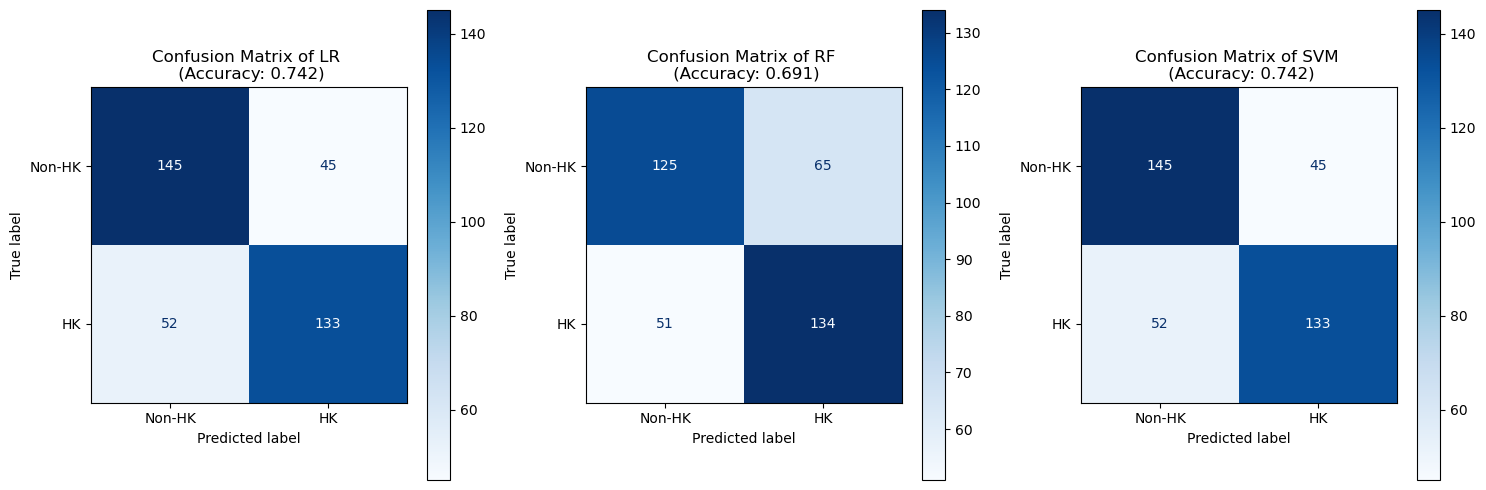

In [19]:
def performance_test(best_clf, X_test, y_test):
  
  model_name = ['LR', 'RF', 'SVM']
  fig, ax = plt.subplots(1, 3, figsize = (15, 5)) 

  for i in range(3):
    # predict
    y_pred = best_clf[i][0].fit(X_train, y_train).predict(X_test)
    
    # plot
    accuracy = math.ceil(accuracy_score(y_test, y_pred)*1000)/1000 # round to 3 dp
    ax[i].set_title(f'Confusion Matrix of {model_name[i]} \n (Accuracy: {accuracy})')
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Non-HK', 'HK'])
    disp.plot(cmap = 'Blues', ax = ax[i])

  plt.tight_layout();

# deploy
performance_test(best_clf, X_test, y_test)

Testing results have significantly better performance than validation results while RF is still the model with the worst performance (0.691).

Surprisingly, **both LR and SVM have identical results, achieving 0.742 accuracy**, 133 TP, and 145 TN. Moreover, with number of TN > TP, this means that the model is better at classifying Non-HK usernames.

## 6. Evaluation and Conclusion

### 6.1 Model Selection

To wrap up, I would choose **SVM** over LR for **actual deployment** due to its **scalability**. Even though they show a similar performance, as the dataset grows larger, LR may face challenges in capturing non-linear relationships of the syllables effectively. On the other hand, SVM is capable of handling non-linear relationships and can scale well to accommodate larger datasets with well-tuned hyperparameters and the kernel trick. However, if **simplicity and computational cost are the main concerns**, LR might be a more suitable choice to work with a small dataset. 

> *try HK-Insta-Identifier yourself on my [streamlit app](https://hk-insta-identifier.streamlit.app/)!*

### 6.2 Limitations 

Username analysis is a *super super* complicated topic because of the freedom and creativity users have when choosing their usernames, for example:  

- **Private account holders** may choose *not* to include their **government (Cantonese) names** in their usernames 
- **English names** are widely adopted by many Hong Kong users and greatly reduce the visibility of linguistic patterns tied to Cantonese
- There is often **overlap among Romanized Chinese dialects**, making it difficult to distinguish between users from different regions  

So while my approach might seem effective enough(? ), you have to carefully consider these factors when interpreting the results of this project.

### 6.3 Thank you & Further Directions

If you find this project interesting, feel free to **star**🌟or **fork** this repo and explore new ideas to build on this work - collaboration is always welcome! 

Possible future directions could include developing a **Romanized Cantonese-specific tokenizer **and incorporating users' bios information.

Thank you again for taking the time to learn about this project!